In [1]:
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

In [2]:
def selection_prob(e_true, th=1.5):
    e_true = np.atleast_1d(e_true)
    res = np.empty_like(e_true)
    
    loge = np.log10(e_true)
    res[loge >= th] = 1
    res[loge < th] = (loge[loge < th]/th)**3
    return res

[]

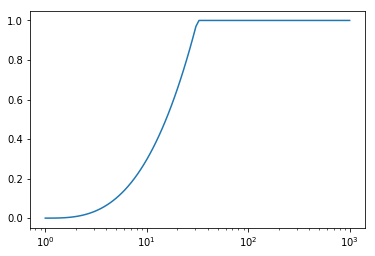

In [3]:
xs = np.logspace(0, 3, 100)
th = 1.5
plt.plot(xs, selection_prob(xs, th))
plt.semilogx()

2.0426785895505843


C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

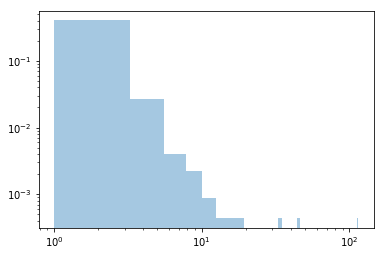

In [73]:
alpha = 2
reco_sigma = 0.2
n_total = 1000
#e_true = stats.lognorm(scale=mu, s=sigma).rvs(10000)
e_true = stats.pareto(alpha).rvs(n_total)
print(np.average(e_true))
sns.distplot(e_true, kde=False, norm_hist=True)
plt.loglog()

[]

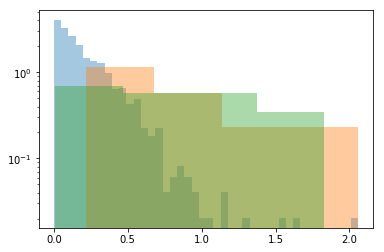

In [81]:
sprob = selection_prob(e_true, th)
#sprob = np.ones_like(e_true)
sel_uni = np.random.uniform(size=e_true.shape)
e_true_det = e_true[sel_uni<=sprob]
sns.distplot(np.log10(e_true), kde=False, norm_hist=True)
sns.distplot(np.log10(e_true_det), kde=False, norm_hist=True)
e_reco_sim = 10**(stats.norm.rvs(loc=np.log10(e_true_det), scale=reco_sigma, size=e_true_det.shape))

sns.distplot(np.log10(e_reco_sim), kde=False, norm_hist=True)
plt.semilogy()

In [ ]:
loge_true_hist =

In [82]:
len(e_true_det)

19

In [118]:
with pm.Model() as model:
    alpha = pm.Gamma("alpha", mu=2, sd=1)
    prior = pm.Pareto("e_true", alpha=alpha, m=1, shape=len(e_reco_sim))
    logprior = tt.log10(prior)
    e_reco = pm.Normal("e_reco", mu=logprior, sd=reco_sigma, observed=np.log10(e_reco_sim))
    
    #prior_undet = 
    
    #pot = pm.Potential("pot", tt.switch(tt.lt(logprior, th), (1-(logprior/th)**3), 0).sum())
    pot = pm.Potential("pot", tt.switch(tt.lt(logprior, th), tt.log((logprior/th)**3), 0))
    trace = pm.sample(tune=2000)
    ppred = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e_true, alpha]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 567.66draws/s]


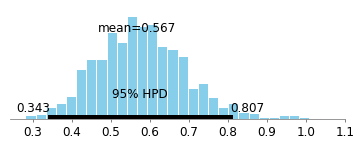

In [119]:
ax = pm.plot_posterior(trace["alpha"])

In [115]:
np.log10(np.average(trace["e_true"], axis=0)).shape

(19,)

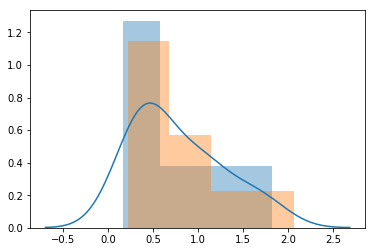

In [116]:
sns.distplot(np.log10(np.average(trace["e_true"], axis=0)))
sns.distplot(np.log10(e_true_det), kde=False, norm_hist=True)


C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ValueError: color kwarg must have one color per data set. 19 data sets and 1 colors were provided

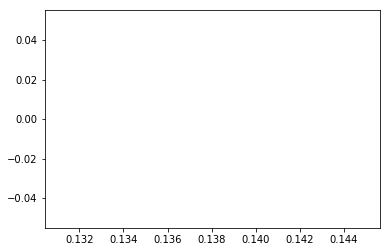

In [98]:
sns.distplot(np.log10(trace["e_true"]), kde=False, label="e_true_smpl")
sns.distplot(np.log10(e_true_det), kde=False, label="e_true")
plt.semilogy()
plt.legend()

[]

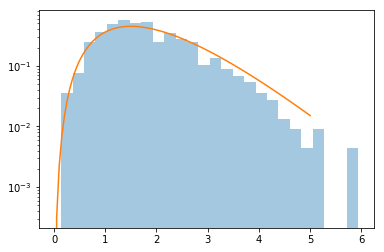

In [34]:
sns.distplot(trace["alpha"], kde=False, norm_hist=True)
#plt.plot(xs, np.exp(model.e_true.distribution.logp(xs).eval()))
#plt.plot(xs, np.exp(pm.Lognormal.dist(mu=np.log(mu), sd=sigma).logp(xs).eval()))
xs = np.linspace(0, 5, 100)
plt.plot(xs, np.exp(pm.Gamma.dist(mu=2, sd=1).logp(xs)).eval())
#pm.traceplot(trace, priors=[, None])
plt.semilogy()

In [14]:
stats.ks_2samp(trace["e_true"], e_true)

Ks_2sampResult(statistic=0.015900000000000025, pvalue=0.790360775257511)